# Classifying spam vs real news

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score


## The dataset

In this world with an influx of information from every outlet, it gets difficult to distinguish between real and fake news. This dataset is a collection of news articles from English blogs, newspaper articles, and news reels.

**Kaggle dataset: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset**

## The goal

The goal for this dataset is to determine if a news article is fake or not. This task would be useful for social media sites to flag incorrect or misleading information to be spread to the public. The decision is should a news article be flagged for spam. The alternatives are at what time of the year is likely to produce fake news articles (maybe during election season?). Or how many fake news articles are about politics?

## Split the dataset

Splitting data into train/test set

In [ ]:
df = pd.read_csv("articles.csv", parse_dates=["date"],  engine='python')
df.head()
df = df.sample(frac=1)
print(df.shape)
df.head()

(44867, 5)


,title,text,subject,date,real
13603,MUST WATCH VIDEO! HERE’S THE MOST IMPORTANT AN...,Politics before anything else that s what Ob...,politics,2016-06-30,False
21327,ILLEGAL IMMIGRANTS CAUGHT Squatting In Deploye...,These creeps will be out of jail and occupying...,left-news,2015-11-13,False
38283,Zimbabwe's ruling party says will never succum...,HARARE (Reuters) - Zimbabwe s ruling ZANU-PF p...,worldnews,2017-11-14,True
3226,Sarah Palin Gets Her A** Handed To Her For Ca...,Sarah Palin opened her mouth again and people ...,News,2016-12-30,False
35861,Red Cross says life has stopped in Myanmar's R...,GENEVA (Reuters) - Life has stopped in its tra...,worldnews,2017-12-13,True


In [ ]:
df_train, df_test = train_test_split(df, random_state=123, train_size=0.80)
y_train = df_train["real"]
df_train = df_train.drop("real", axis=1)
y_test = df_test["real"]
df_test = df_test.drop("real", axis=1)

print("train size:", df_train.shape)
print("test size:", df_test.shape)

train size: (35893, 4)
test size: (8974, 4)


## Exploratory data analysis

Training dataset has no missing values and an even split in target column `real` so there is no class imbalance.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35893 entries, 5675 to 44770
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    35893 non-null  object        
 1   text     35893 non-null  object        
 2   subject  35893 non-null  object        
 3   date     35893 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.4+ MB


In [ ]:
y_train.value_counts()

False    18750
True     17143
Name: real, dtype: int64

In [ ]:
df_train["subject"].value_counts()

politicsNews       9053
worldnews          8090
News               7249
politics           5483
left-news          3549
Government News    1254
US_News             609
Middle-east         606
Name: subject, dtype: int64

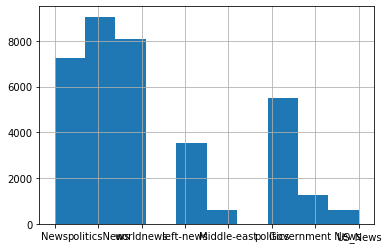

In [ ]:
df_train["subject"].hist()

`subject` column is categorical with government and political categories as the dominant values. There is some overlap in the types, `News` can cover `worldnews` and `US_News` types.

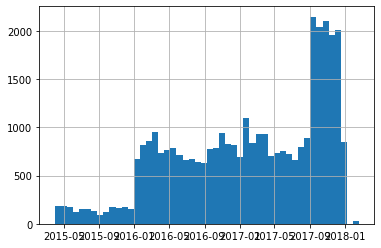

In [ ]:
df_train["date"].hist(bins = 50)

There is only one numeric feature, `date`, which does not have as much data from 2015 and has a lot more data for 2017-2018.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec875f5518>]],
      dtype=object)

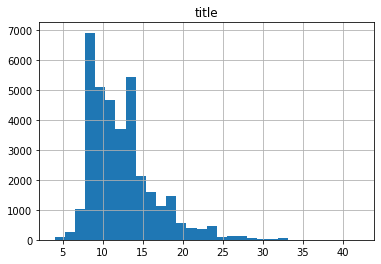

In [ ]:
title_count = pd.DataFrame(df_train['title'].str.split().apply(len))
title_count.hist(bins = 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec87060400>]],
      dtype=object)

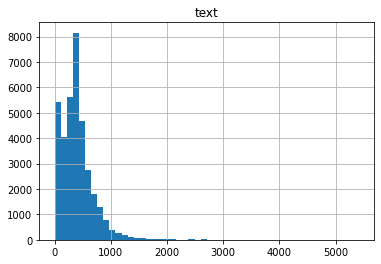

In [ ]:
text_count = pd.DataFrame(df_train['text'].str.split().apply(len))
text_count.hist(bins = 50)

For `title` column, most datapoints are clustered in the 12 word count range but there is some outliers with more than 30 words. For `text` column, most data points are in the 100 - 1000 word range.

Text(0, 0.5, 'title')

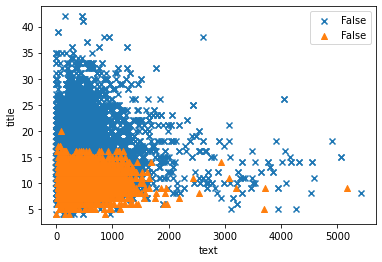

In [ ]:
plt.scatter(text_count["text"][~y_train],title_count["title"][~y_train], marker = "x")
plt.scatter(text_count["text"][y_train],title_count["title"][y_train], marker = "^")

plt.legend(labels=y_train)
plt.xlabel("text")
plt.ylabel("title")

Upon further inspection of the text columns, there is some outliers some fake and real articles with more than 5000 text words. It seems real news articles are limited to less than 20 words but fake ones with more than 40 words are outliers.

## Data cleaning
The raw dataset does not have many features to begin with but the articles themselves have many words. I will drop the `title` column because there is not as many words to work with. I will also drop the `subject` column because the categories are pretty vague and does not provide a clear division of what kind of news it is. It would've been preferable to have political, sports, and entertainment etc; but the current values are not helpful.

## The preprocessing pipeline

In [ ]:
categorical_features = 'text'
numerical_features = ['date']
drop_features = ['title', 'subject'] 

In [ ]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
]) 
categorical_transformer = Pipeline([
    ('countvec', CountVectorizer(binary=True))
])
preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
])

## Exploratory baseline models

Some basic models with default parameters to help identify the best model to use.

Especially with DummyClassifier as a baseline, any chosen model must perform better than this one.


In [ ]:
pipe_dummy = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyClassifier())])
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))])
pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier())])
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier())])
pipe_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())])

In [ ]:
classifiers = {
    'dummy' : pipe_dummy,
    'logistic regression' : pipe_lr,
    'LightGBM' : pipe_lgbm,
    'decision tree' : pipe_tree,
    'random forest' : pipe_forest
}
mean_results_dict = dict()
std_results_dict = dict()
for name, classifier in classifiers.items():
    print(name)
    result = pd.DataFrame(cross_validate(classifier, df_train, y_train, return_train_score=True))
    mean_results_dict[name] = result.mean()
    std_results_dict[name] = result.std()

dummy


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarn

logistic regression
LightGBM
decision tree
random forest


In [ ]:
results = pd.DataFrame(mean_results_dict).T
std_results  = pd.DataFrame(std_results_dict).T
results = results.assign(test_score_std=std_results["test_score"])
results.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score,test_score_std
logistic regression,13.081576,2.275804,0.998133,0.999972,0.000159
LightGBM,39.647902,2.406774,0.997938,0.999993,0.000552
decision tree,17.178085,2.247309,0.996824,1.000000,0.000726
random forest,93.482382,3.217454,0.988104,1.000000,0.000604
dummy,8.725616,2.231008,0.501268,0.498168,0.003156


I used all default hyperparameters for both the classifier and preprocessor. All the classifiers (except for DummyClassifier) performed well but it would be interesting to see if the preprocessing could be further improved on.

## Hyper-parameter tuning

I chose to use a randomized search on LGBM because it is interesting to tune the leaves and the depth of the trees.

In the end, there was very little improvement in tuning the hyperparameters since they all seem to produce the same scores. But I will still use the best parameters returned by the RandomizedSearch, especially `stop_word = 'english'`.

In [ ]:
parameters = {
    'preprocessor__categorical__countvec__stop_words' : ['english'],
    'preprocessor__categorical__countvec__min_df' : np.arange(1,20),
    'model__num_leaves': np.arange(10,70),
    'model__min_data_in_leaf': np.arange(100,1000)
}

In [ ]:
random_search = RandomizedSearchCV(pipe_lgbm, parameters, n_iter = 10, verbose = 1, n_jobs = -1, random_state = 123)

In [ ]:
random_search.fit(df_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.6min finished


In [ ]:
pd.DataFrame(random_search.cv_results_)[['mean_test_score','param_preprocessor__categorical__countvec__min_df','param_model__num_leaves', 'param_model__min_data_in_leaf', 'rank_test_score']].set_index("rank_test_score").sort_index()

,mean_test_score,param_preprocessor__categorical__countvec__min_df,param_model__num_leaves,param_model__min_data_in_leaf
rank_test_score,,,,
1,0.997994,4,43,115
2,0.997938,6,45,124
3,0.997910,14,54,343
4,0.997883,4,35,270
5,0.997855,7,60,268
6,0.997743,9,20,673
7,0.997688,19,31,688
8,0.997465,8,47,778
9,0.997158,11,17,969


## Cross-validation scores
The cross-validation scores for all folds are similar to each other; we can assume that it is a good approximation of the test score.


In [ ]:
best_params = random_search.best_params_
best_params

{'model__min_data_in_leaf': 115,
 'model__num_leaves': 43,
 'preprocessor__categorical__countvec__min_df': 4,
 'preprocessor__categorical__countvec__stop_words': 'english'}

In [ ]:
numeric_transformer_final = Pipeline([
    ('scaler', StandardScaler())
]) 
categorical_transformer_final = Pipeline([
    ('countvec', CountVectorizer(binary=True, stop_words = "english", min_df=best_params["preprocessor__categorical__countvec__min_df"]))
])
preprocessor_final = ColumnTransformer([
        ('numeric', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
])
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(num_leaves= best_params["model__num_leaves"], min_data_in_leaf = best_params["model__min_data_in_leaf"]))])
pd.DataFrame(cross_validate(pipe_final, df_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,37.292358,2.582725,0.997493,1.000000
1,37.858940,2.517154,0.997632,1.000000
2,37.976185,2.499164,0.997632,0.999965
3,38.135649,2.489494,0.997771,1.000000
4,37.598339,2.538036,0.998885,1.000000


## Training Score

Of all the actual news articles, the model was able to capture 99% of them.

According to the precision score, there was no false positives, any social media sites using this model would not mislabel real news as fake news.




In [ ]:
pipe_final.fit(df_train, y_train);

In [ ]:
print("recall score: ", recall_score(y_train, pipe_final.predict(df_train)))
print("precision score: ", precision_score(y_train, pipe_final.predict(df_train)))

recall score:  0.9999416671527738
precision score:  1.0


## Test Score

The model performed very well on the test set.However, it does not deal with imputation and only uses English stop words from sklearn. If there are missing data or foreign articles in deployment data, then its perfomance will probably go down.

The model could further be improved on by using groups of words as a single column instead of just using one word per feature. I also treated `date` column as a numerical value when it could be processed as a seasonal/monthly feature. This way, it could capture times when fake news is more likely (if such a pattern exists).

In [ ]:
pipe_final.score(df_test, y_test)

0.9976599063962559